In [20]:
# Market Mix Modelling (MMM) Project
# Objective: Analyze how various marketing channels contribute to overall sales

# Step 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import GridSearchCV


In [5]:
# Step 2: Generate Synthetic Data
def generate_data(n=100):
    np.random.seed(42)
    time = np.arange(n)
    tv_spend = np.random.uniform(100, 500, size=n)
    digital_spend = np.random.uniform(50, 300, size=n)
    radio_spend = np.random.uniform(20, 100, size=n)

    # Adding seasonal effect and noise
    seasonality = 50 * np.sin(2 * np.pi * time / 12)
    noise = np.random.normal(0, 30, size=n)

    # Sales as a function of marketing spends and seasonality
    sales = (
        0.3 * tv_spend +
        0.4 * digital_spend +
        0.2 * radio_spend +
        seasonality +
        noise
    )

    data = pd.DataFrame({
        'time': time,
        'tv_spend': tv_spend,
        'digital_spend': digital_spend,
        'radio_spend': radio_spend,
        'sales': sales
    })
    return data

# Generate and preview data
data = generate_data()
print(data.head())



   time    tv_spend  digital_spend  radio_spend       sales
0     0  249.816048      57.857296    71.362532  113.727394
1     1  480.285723     209.102603    26.731197  238.524987
2     2  392.797577     128.588995    32.930297  283.480523
3     3  339.463394     177.142673    91.884335  260.090525
4     4  162.407456     276.891618    68.514325  155.728742


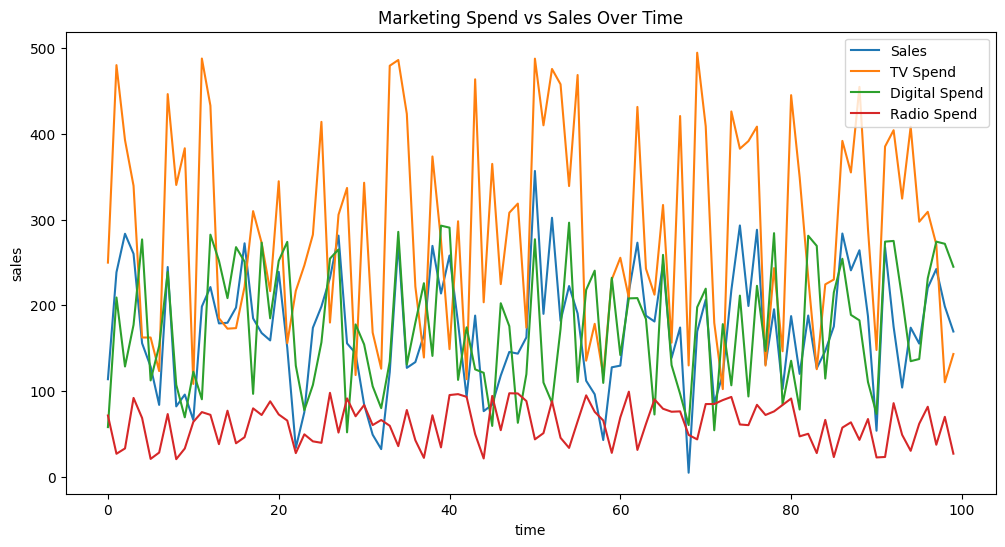

In [7]:
# Step 3: Exploratory Data Analysis (EDA)
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='time', y='sales', label='Sales')
sns.lineplot(data=data, x='time', y='tv_spend', label='TV Spend')
sns.lineplot(data=data, x='time', y='digital_spend', label='Digital Spend')
sns.lineplot(data=data, x='time', y='radio_spend', label='Radio Spend')
plt.legend()
plt.title("Marketing Spend vs Sales Over Time")
plt.show()


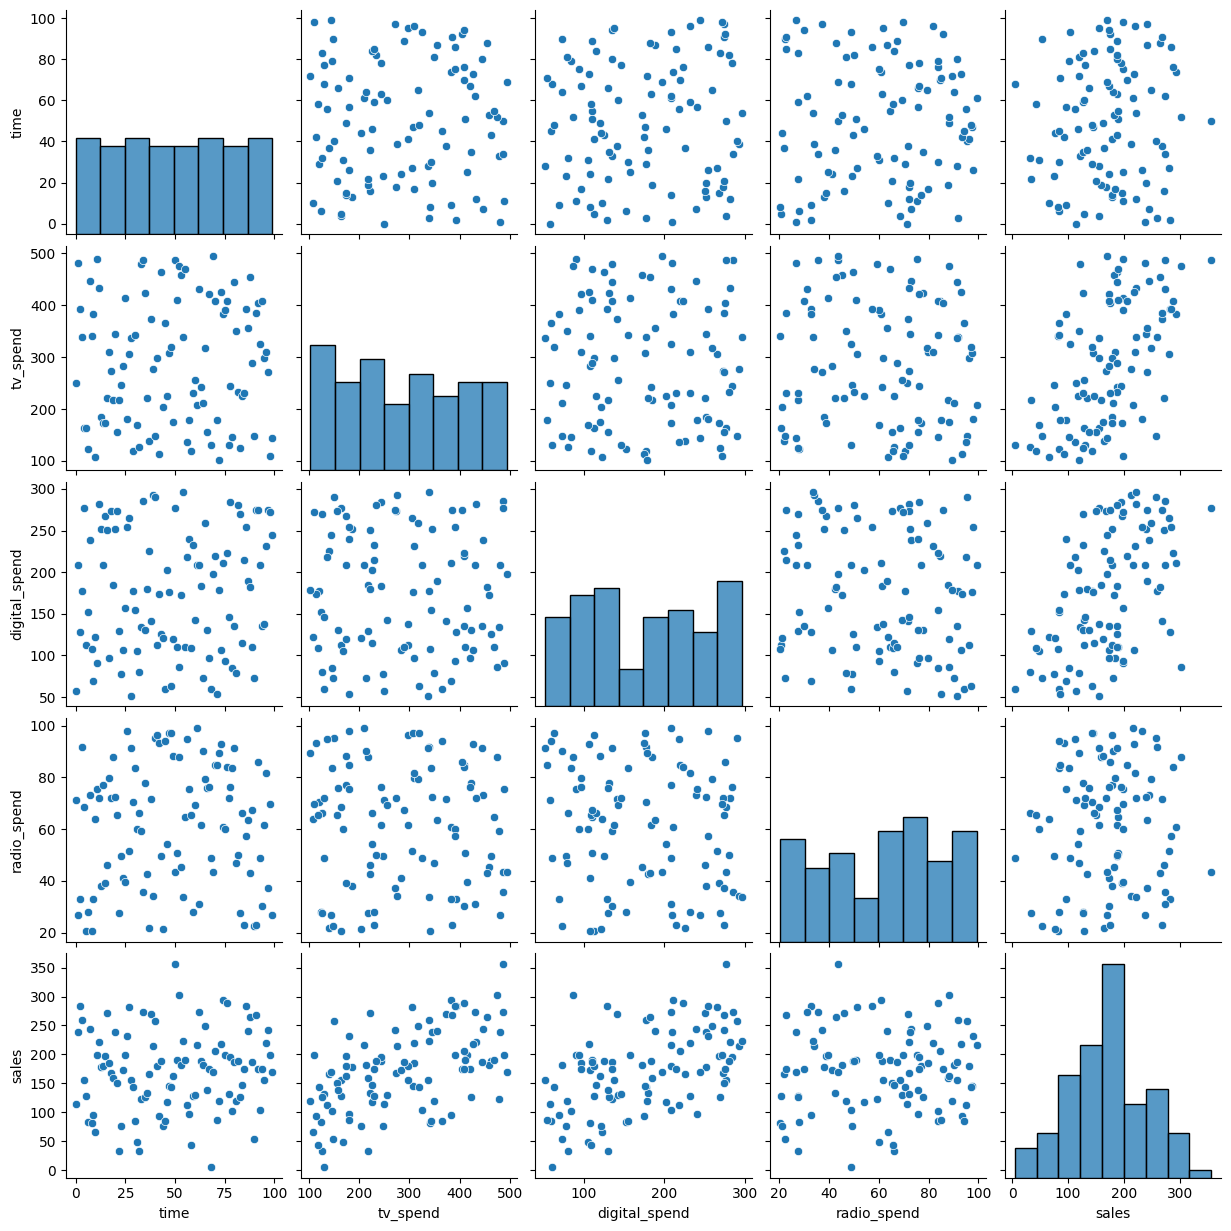

In [8]:
sns.pairplot(data)
plt.show()


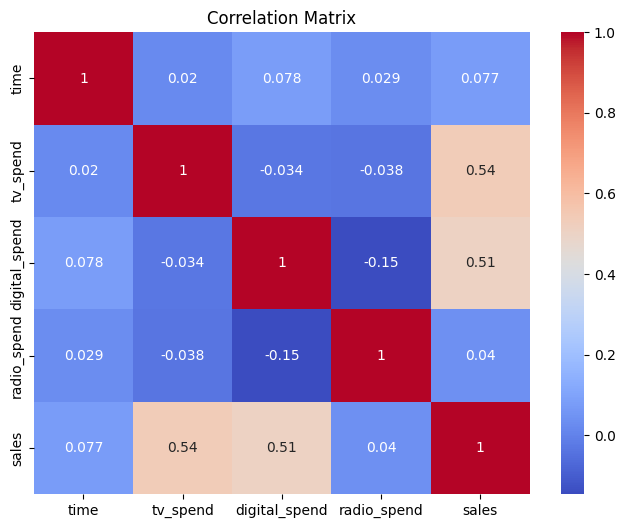

In [9]:
# Correlation Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


In [10]:
# Step 4: Preprocessing and Feature Engineering
# Feature Engineering: Adding lagged features and interaction terms
data['lagged_tv_spend'] = data['tv_spend'].shift(1).fillna(0)
data['lagged_digital_spend'] = data['digital_spend'].shift(1).fillna(0)
data['lagged_radio_spend'] = data['radio_spend'].shift(1).fillna(0)

data['tv_digital_interaction'] = data['tv_spend'] * data['digital_spend']
data['tv_radio_interaction'] = data['tv_spend'] * data['radio_spend']
data['digital_radio_interaction'] = data['digital_spend'] * data['radio_spend']

In [11]:
# Step 4.1: Multicollinearity Check (VIF)
def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

# Check VIF before splitting the data
X_features = data[['tv_spend', 'digital_spend', 'radio_spend', 'lagged_tv_spend', 'lagged_digital_spend', 'lagged_radio_spend',
                   'tv_digital_interaction', 'tv_radio_interaction', 'digital_radio_interaction']]
vif = calculate_vif(X_features)
print("Variance Inflation Factor (VIF):")
print(vif)



Variance Inflation Factor (VIF):
                     Feature        VIF
0                   tv_spend  56.065322
1              digital_spend  44.531219
2                radio_spend  46.390803
3            lagged_tv_spend   6.703922
4       lagged_digital_spend   6.805540
5         lagged_radio_spend   7.928590
6     tv_digital_interaction  39.746626
7       tv_radio_interaction  42.163330
8  digital_radio_interaction  37.787924


In [12]:
# Step 4.2: Addressing Multicollinearity
# Feature Selection (Removing variables with high VIF)
X_reduced = X_features.drop(columns=['tv_digital_interaction', 'tv_radio_interaction', 'digital_radio_interaction'])

# Dimensionality Reduction (PCA)
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_reduced)
print("Explained Variance Ratios (PCA):", pca.explained_variance_ratio_)

# Ridge Regression will also help manage multicollinearity (no additional step needed)


Explained Variance Ratios (PCA): [0.3727987  0.33700783 0.13595374 0.12749552 0.01456645]


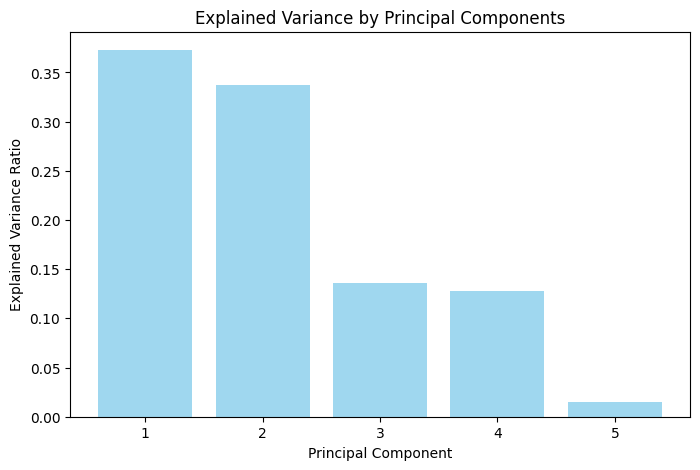

In [14]:
# Visualizing PCA Results
# Bar plot of explained variance ratios
plt.figure(figsize=(8, 5))
plt.bar(range(1, 6), pca.explained_variance_ratio_, color='skyblue', alpha=0.8)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Explained Variance by Principal Components")
plt.show()


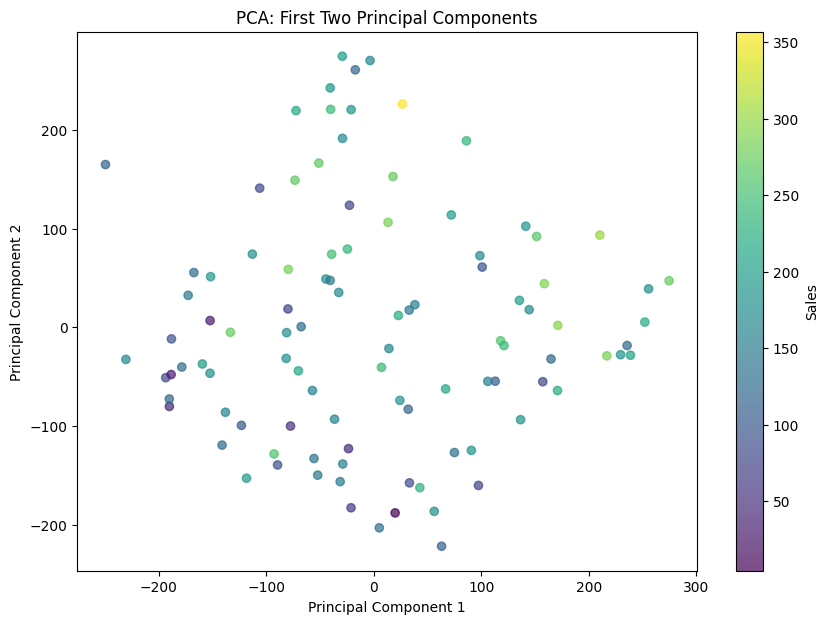

In [15]:
# Scatter plot of first two principal components
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data['sales'], cmap='viridis', alpha=0.7)
plt.colorbar(label='Sales')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA: First Two Principal Components")
plt.show()

In [21]:
# Step 5: Model Building and Training
X = pd.DataFrame(X_pca)
y = data['sales']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Most variables have extremely high VIF values (e.g., tv_spend, digital_spend, and their interaction terms), indicating a significant multicollinearity problem.

In [22]:

# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Ridge Regression
ridge_model = Ridge()
param_grid = {'alpha': np.logspace(-6, 6, 13)}  # Trying different alpha values
grid_search = GridSearchCV(ridge_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_ridge_model = grid_search.best_estimator_


In [23]:
# Step 6: Model Evaluation
def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    print("Train R^2:", r2_score(y_train, y_train_pred))
    print("Test R^2:", r2_score(y_test, y_test_pred))
    print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))

    return y_test_pred

print("Linear Regression Performance")
linear_preds = evaluate_model(linear_model, X_train, y_train, X_test, y_test)

print("\nBest Ridge Regression Performance (After Tuning)")
ridge_preds = evaluate_model(best_ridge_model, X_train, y_train, X_test, y_test)



Linear Regression Performance
Train R^2: 0.5748737529363287
Test R^2: 0.37117995792047676
Test RMSE: 54.23549856266373

Best Ridge Regression Performance (After Tuning)
Train R^2: 0.5748737529363287
Test R^2: 0.371179957920615
Test RMSE: 54.235498562657774


In [24]:
rolling_window = 3
linear_preds_smoothed = pd.Series(linear_preds).rolling(window=rolling_window).mean().dropna()
ridge_preds_smoothed = pd.Series(ridge_preds).rolling(window=rolling_window).mean().dropna()
y_test_smoothed = pd.Series(y_test.values).rolling(window=rolling_window).mean().dropna()

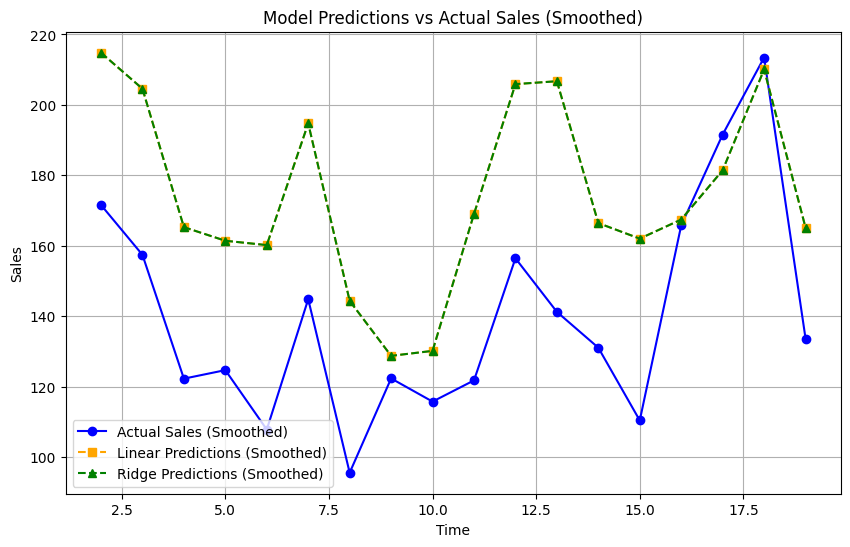

In [25]:
# Step 7: Visualizing Model Predictions
plt.figure(figsize=(10, 6))
plt.plot(y_test_smoothed, label="Actual Sales (Smoothed)", marker='o', linestyle='-', color='blue')
plt.plot(linear_preds_smoothed, label="Linear Predictions (Smoothed)", linestyle='--', marker='s', color='orange')
plt.plot(ridge_preds_smoothed, label="Ridge Predictions (Smoothed)", linestyle='--', marker='^', color='green')
plt.legend()
plt.title("Model Predictions vs Actual Sales (Smoothed)")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.grid(True)
plt.show()




In [ ]:
# Step 8: Documentation and Save Outputs
data.to_csv("data/marketing_data.csv", index=False)
X_test.to_csv("data/test_features.csv", index=False)
pd.DataFrame({"Actual Sales": y_test, "Linear Predictions": linear_preds, "Ridge Predictions": ridge_preds}).to_csv("data/predictions.csv", index=False)

print("Project completed and results saved!")
